# <center> Домашнее задание 5</center>

**1. [15 баллов]** Изучите [набор данных](https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset) по сотрудникам одной крупной IT компании. Посмотрите на описательные статистики по всем столбцам (как по количественным, так и по порядковым и категориалным переменным). В переменной ```JobSatisfaction``` приведите значения к бинарному виду. Значения $1$ и $2$ должны стать нулями, а значения от $3$ до $4$ - единицами. 

**2. [20 баллов]** Отберите N признаков (подвыборку наиболее важных, на ваш взгляд, признаков или все имеющиеся) и постройте модель логистической регрессии с k-fold кросс-валидацией ($k=5$) и $L_2$ регуляризацией, где в качестве целевой переменной будем предсказывать удовлетворенность работой по преобразованной переменной ```JobSatisfaction``` ($0$ - неудовлетворенность, $1$ - удовлетворенность). Напишите, какой это тип задачи машинного обучения (регрессия, кластеризация или что-то другое). Проинтерпретируйте полученные коэффициенты обученной модели. 

**3. [20 баллов]** Постройте дерево решений на всех признаках, используя энтропийный критерий, и визуализируйте его через библиотеку graphviz (или sklearn.export_graphiz и импорт изображения). Проинтерпретируйте, через какие предикаты в дереве (логические выражения признаков и их значений) Вы получили предсказания положительного класса (для всех листьев с предсказанием $1$).

**4. [20 баллов]** Обучите случайный лес и подберите к нему параметры ```n_estimators, max_depth, min_samples_leaf, max_features```, используя ```GridSearchCV``` или ```RandomizedSearchCV```.

**5. [25 баллов]** Создайте предсказания для вашей выборки, имитируя константный (всегда предсказывающий метку класса 1) и случайный (для каждого наблюдения равновероятно предсказывающий метки класса $1$ или $0$) классификаторы. Постройте ROC кривые для логистической регрессии, дерева решений, случайного леса, константного и случайного классификаторов на одном графике и сделайте выводы о качестве полученных моделей. Для лучшей (по метрике AUC) модели посчитайте матрицу ошибок, Accuracy, Precision и Recall. 

* **Бонусное [30 баллов]** Придумайте 10 новых признаков на основе имеющихся и при построении модели покажите, что суммарно они улучшают качество вашей лучшей модели хотя бы на 3% (по метрике AUC).

In [473]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats 
from scipy.optimize import minimize
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from scipy.special import expit
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

In [474]:
data = pd.read_csv('HR.csv')

In [475]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,1470.0,36.923810,9.135373,18.0,30.00,36.0,43.00,60.0
DailyRate,1470.0,802.485714,403.509100,102.0,465.00,802.0,1157.00,1499.0
DistanceFromHome,1470.0,9.192517,8.106864,1.0,2.00,7.0,14.00,29.0
Education,1470.0,2.912925,1.024165,1.0,2.00,3.0,4.00,5.0
EmployeeCount,1470.0,1.000000,0.000000,1.0,1.00,1.0,1.00,1.0
EmployeeNumber,1470.0,1024.865306,602.024335,1.0,491.25,1020.5,1555.75,2068.0
EnvironmentSatisfaction,1470.0,2.721769,1.093082,1.0,2.00,3.0,4.00,4.0
HourlyRate,1470.0,65.891156,20.329428,30.0,48.00,66.0,83.75,100.0
JobInvolvement,1470.0,2.729932,0.711561,1.0,2.00,3.0,3.00,4.0
JobLevel,1470.0,2.063946,1.106940,1.0,1.00,2.0,3.00,5.0


In [476]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [477]:
data.shape

(1470, 35)

In [478]:
data.isna().sum(axis=0)

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

In [479]:
dummies = pd.get_dummies(data, columns = ['BusinessTravel', 'Gender', 'OverTime', 'Over18', 'MaritalStatus', 'JobRole', 'Department', 'EducationField', 'Attrition'])
pd.concat([data, dummies], axis = 1)
dummies.describe().iloc[:, 27:].transpose()

,count,mean,std,min,25%,50%,75%,max
BusinessTravel_Travel_Frequently,1470.0,0.188435,0.391193,0.0,0.0,0.0,0.0,1.0
BusinessTravel_Travel_Rarely,1470.0,0.709524,0.454137,0.0,0.0,1.0,1.0,1.0
Gender_Female,1470.0,0.400000,0.490065,0.0,0.0,0.0,1.0,1.0
Gender_Male,1470.0,0.600000,0.490065,0.0,0.0,1.0,1.0,1.0
OverTime_No,1470.0,0.717007,0.450606,0.0,0.0,1.0,1.0,1.0
OverTime_Yes,1470.0,0.282993,0.450606,0.0,0.0,0.0,1.0,1.0
Over18_Y,1470.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
MaritalStatus_Divorced,1470.0,0.222449,0.416033,0.0,0.0,0.0,0.0,1.0
MaritalStatus_Married,1470.0,0.457823,0.498387,0.0,0.0,0.0,1.0,1.0
MaritalStatus_Single,1470.0,0.319728,0.466530,0.0,0.0,0.0,1.0,1.0


In [480]:
data['BusinessTravel'].describe()

count              1470
unique                3
top       Travel_Rarely
freq               1043
Name: BusinessTravel, dtype: object

In [481]:
cat = ['Gender', 'OverTime', 'Over18', 'MaritalStatus', 'JobRole', 'Department', 'EducationField', 'Attrition']
data[cat].describe()

,Gender,OverTime,Over18,MaritalStatus,JobRole,Department,EducationField,Attrition
count,1470,1470,1470,1470,1470,1470,1470,1470
unique,2,2,1,3,9,3,6,2
top,Male,No,Y,Married,Sales Executive,Research & Development,Life Sciences,No
freq,882,1054,1470,673,326,961,606,1233


In [482]:
# Job satisfaction is an integer number
data['JobSatisfaction'] = data['JobSatisfaction'].replace([1, 2, 3, 4], [0, 0, 1, 1])
data['JobSatisfaction']

0       1
1       0
2       1
3       1
4       0
       ..
1465    1
1466    0
1467    0
1468    0
1469    1
Name: JobSatisfaction, Length: 1470, dtype: int64

**2. [20 баллов]** Отберите N признаков (подвыборку наиболее важных, на ваш взгляд, признаков или все имеющиеся) и постройте модель логистической регрессии с k-fold кросс-валидацией ($k=5$) и $L_2$ регуляризацией, где в качестве целевой переменной будем предсказывать удовлетворенность работой по преобразованной переменной ```JobSatisfaction``` ($0$ - неудовлетворенность, $1$ - удовлетворенность). Напишите, какой это тип задачи машинного обучения (регрессия, кластеризация или что-то другое). Проинтерпретируйте полученные коэффициенты обученной модели. 



Данный тип задачи машинного обучения – классификация, поскольку фактически это задача распознавания образов. В обучающей выборке есть набор объектов, которые можно охарактеризовать вектором признаков, необходимо по вектору признаков x вернуть метку класса или вектор оценок принадлежности для тестовой выборки. Это можно сделать через некий алгоритм. Это и есть то, что нужно сделать в данной задаче

In [483]:
predictor = ['Age', 'EnvironmentSatisfaction','JobLevel', 'DailyRate', 'DistanceFromHome', 'HourlyRate', 'MonthlyIncome']
y = data.JobSatisfaction.values
X = data[predictor].values
# t = dummies.drop(['JobSatisfaction'], axis = 1)

In [484]:
# from sklearn.linear_model import LogisticRegression
# logit = LogisticRegression()
# HR_logit = logit.fit(X, y)
# HR_logit.coef_

In [485]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=99)

model = LogisticRegression(penalty='l2', C=1e10)

scaler_x = MinMaxScaler()

X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(y_train.reshape((-1,1))).reshape(-1)
y_test = scaler_y.transform(y_test.reshape((-1,1))).reshape(-1)

model = model.fit(X_train, y_train)
result = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
result.mean()

0.5300535217907887

In [486]:
model.coef_

array([[-0.05339354, -0.13407148,  0.91064759,  0.4371422 ,  0.07047936,
        -0.34389211, -0.84308276]])

Как можно видеть коэффиценты имеют весомый разброс. Такие коэффициенты, как возраст и расстояние от дома практически не влияют на удовлетвернность работой, так как их значение невосыко и меньше 0,1 по модулю. Наибольее значимыми являются следующие коэффициенты: Job level (0.9), Monthly Income (-0.84), Hourly rate (0.44). Причем полижительные коэффициенты связаны прямой зависимостью с удовлетворенностью работой, а  отрицательные показывают возрастание значения предсказываемой переменной при убывание значения по другой, но это может продолжаться до определенного порогового значения. Положительный коэффициент регрессии означает, что данный фактор повышает вероятность предсказываемого события, а  отрицательный коэффициент показывает снижение вероятности; чем больше значение коэфа по модулю, тем большее влияние он оказывает на результат предсказания.

In [487]:
from sklearn.metrics import plot_roc_curve, precision_recall_curve, auc, roc_curve
y_pred = model.predict_proba(X_test)[:,1]
fpr, tpr, _= roc_curve(y_test, y_pred)
auc(fpr, tpr)

0.5430926858668044

In [488]:
# Это надо было для тестов
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=99)

model = LogisticRegression( )

result= cross_val_predict (model, X_train, y_train, cv=5)
result

array([1, 1, 1, ..., 1, 1, 1])

In [489]:
# print(classification_report(y_train, result))

**3. [20 баллов]** Постройте дерево решений на всех признаках, используя энтропийный критерий, и визуализируйте его через библиотеку graphviz (или sklearn.export_graphiz и импорт изображения). Проинтерпретируйте, через какие предикаты в дереве (логические выражения признаков и их значений) Вы получили предсказания положительного класса (для всех листьев с предсказанием $1$).

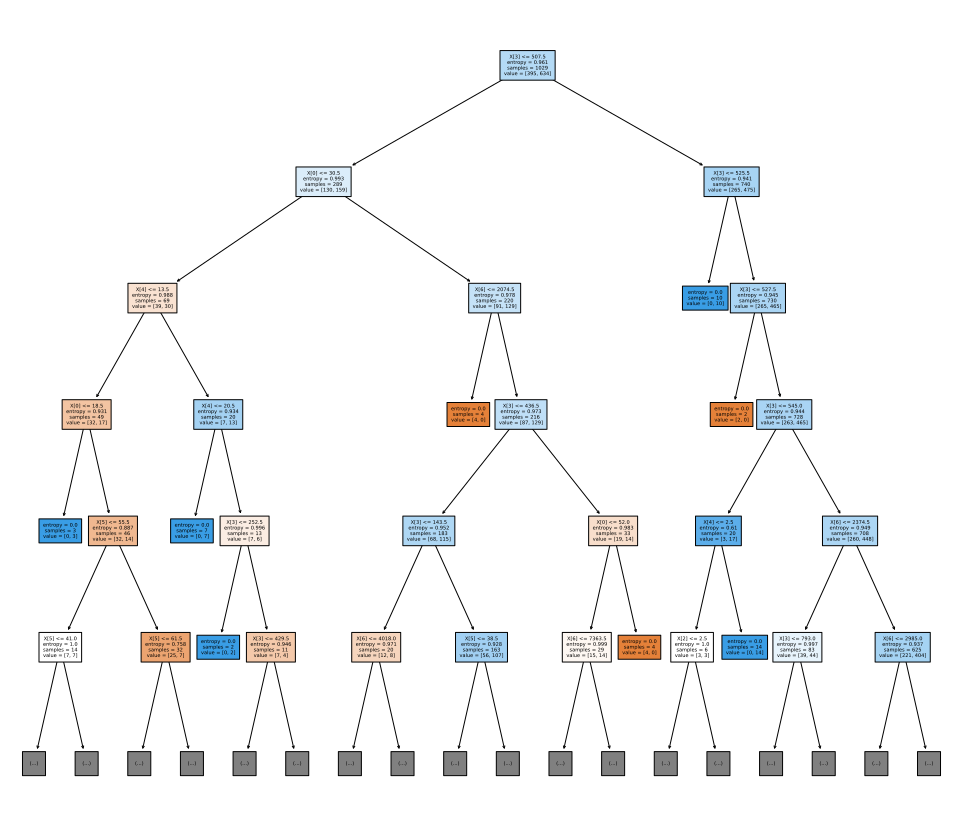

In [490]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from pylab import rcParams
%config InlineBackend.figure_format = 'svg' 
clf = DecisionTreeClassifier(criterion='entropy')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=99)
clf = clf.fit(X_train, y_train)
rcParams["figure.figsize"] = [17, 15]
tree.plot_tree(clf, fontsize = 5,filled = True, max_depth = 5);

Покажем на примере одного листка, как работает дерево принятия решений. Возьмем для примера блок на нижнем уровне, у которого значения следующие:

- entropy = 0.0
- samples = 14
- value = [0, 14]

Несложно с помощью метода count для массива посчитать values = 1 для трэйна, чтобы определить что находится в корне дерева. Итого получаем, что из 1029 samples по значению Job Satisfaction 395 образцов имеют значение 0, 634 – 1. Стрелочки распределены так, что для каждого блока вопросов стрелочка с правой стороны означает ответ на вопрос да, с левой – нет.

Дерево работает следующим образом. Когда мы хотим прогнать тестовую выборку по сформированному дереву, то начинаем с самого верха с первого вопроса, и так далее. 

Опишем цепочку действий:

1) Daily rate < 507.5? - да. Идём по стрелочке налево.

2) Возраст < 30.5? - да. Идём по стрелочке налево.

3) Расстояние от дома < 13.5 -  нет. Идём по стрелочке направо.

4) Расстояние от дома < 20.5 -  нет. Идём по стрелочке направо.

5) Daily rate < 252.5? - да. Идём по стрелочке налево.


И на этом моменте дерево всегда будет классифицировать тестовый sample как тот, у которого Job Satisfaction = 1. В тестовой выборке таких значений 2, что не является высоким показателем вероятности, но делать нечего.

Остальные листья рассматриваются аналогично

In [20]:
from sklearn.metrics import roc_auc_score

model_t = DecisionTreeClassifier(max_depth=5, random_state = 99)
model_t.fit(X_train, y_train)

y_predicted_tree = model_t.predict_proba(X_test)[:,1]
fpr, tpr, _= roc_curve(y_test, y_predicted_tree)
auc(fpr, tpr)


0.5332881312152912

**4. [20 баллов]** Обучите случайный лес и подберите к нему параметры ```n_estimators, max_depth, min_samples_leaf, max_features```, используя ```GridSearchCV``` или ```RandomizedSearchCV```.

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_roc_curve, precision_recall_curve, auc
clf_forest = RandomForestClassifier(random_state = 99)
clf_forest = clf_forest.fit(X_train, y_train)

In [22]:
y_pred_forest = clf_forest.predict_proba(X_test)[:, 1]

In [23]:
fpr, tpr, _ = roc_curve(y_test, y_pred_forest)
auc(fpr, tpr)

0.5426729519135565

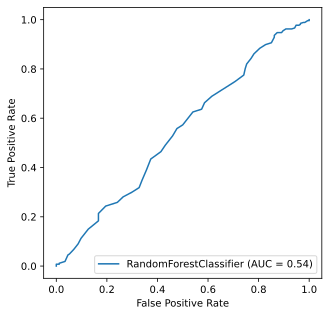

In [199]:
%config InlineBackend.figure_format = 'svg' 
rcParams["figure.figsize"] = [5, 5]
plot_roc_curve(clf_forest, X_test, y_test);

In [71]:
from sklearn.model_selection import train_test_split, GridSearchCV

parameters = {'n_estimators': [i for i in range(10,40)],
              'min_samples_leaf': [3,4,5,6,7],
              'max_features':['auto', 'sqrt'],
              'max_depth':[5,8,10]
             }

clf_forest = RandomForestClassifier()

clf_grid = GridSearchCV(estimator=clf_forest, param_grid=parameters, scoring='roc_auc', cv=5, n_jobs=-1)
clf_grid.fit(X, y)
print('Лучший результат:', clf_grid.best_score_)
print('Лучшие параметры:', clf_grid.best_params_)

Лучший результат: 0.5523592105668212
Лучшие параметры: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'n_estimators': 13}


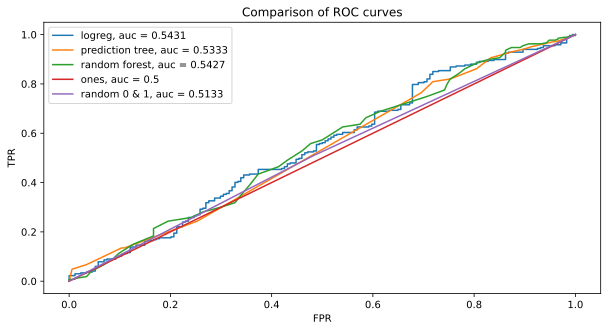

In [200]:
from sklearn.metrics import roc_curve
%config InlineBackend.figure_format = 'svg' 
rcParams["figure.figsize"] = [10, 5]
fpr, tpr, t = roc_curve(y_test, y_pred)
s = str(np.round(auc(fpr, tpr),  decimals=4))
plt.plot(fpr, tpr, label='logreg, auc = '+s)

fpr, tpr, t = roc_curve(y_test, y_predicted_tree)
s = str(np.round(auc(fpr, tpr),  decimals=4))
plt.plot(fpr, tpr, label='prediction tree, auc = '+s)

fpr, tpr, t = roc_curve(y_test, y_pred_forest)
s = str(np.round(auc(fpr, tpr),  decimals=4))
plt.plot(fpr, tpr, label='random forest, auc = '+s)

ones = np.ones(y_test.size)
fpr, tpr, t = roc_curve(y_test, ones)
s = str(np.round(auc(fpr, tpr),  decimals=4))
plt.plot(fpr, tpr, label='ones, auc = '+s)

random = np.random.randint(2, size=y_test.size)
fpr, tpr, t = roc_curve(y_test, random)
s = str(np.round(auc(fpr, tpr),  decimals=4))
plt.plot(fpr, tpr, label='random 0 & 1, auc = '+s)

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Comparison of ROC curves')

plt.legend();

График, построенный выше демонстрирует, что полученные модели хоть и отличаются от моделей, выведенных с помощью константного и случайного классификаторов, но тем не менее из-за специфичности представленной выборки, значения auc для логистической регресии, дерева и случайного леса не так заметно отличаются от значений из вышеупомянутых классификаторов, что в свою очередь с одной стороны говорит о несостотельности,полученных моделей, но с другой стороны демонстрирует некоторые преимущества в сравнении с рандомным и константым классификаторами. Логистическая регресия имеет наибольший auc индекс, поэтому всюду далее будем работать именно с ней

 ## Для лучшей (по метрике AUC) модели посчитайте матрицу ошибок, Accuracy, Precision и Recall.

In [274]:
cm = confusion_matrix(y_test, y_pred>0.6)

In [275]:
cm

array([[ 69, 105],
       [ 91, 176]])

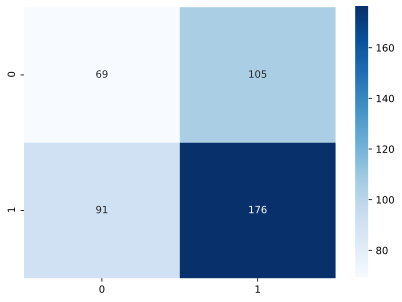

In [285]:
%config InlineBackend.figure_format = 'svg' 
rcParams["figure.figsize"] = [7, 5]
sns.heatmap(cm, annot = True, fmt='', cmap = 'Blues')

In [286]:
from sklearn.metrics import recall_score, precision_score, accuracy_score
precision_score(y_test, y_pred>0.6)

0.6263345195729537

In [287]:
recall_score(y_test, y_pred>0.6)

0.6591760299625468

In [288]:
accuracy_score(y_test, y_pred>0.6)

0.5555555555555556

## Дополнительное задание

In [596]:
predictor = ['Age', 'EnvironmentSatisfaction','JobLevel', 'DailyRate', 'DistanceFromHome', 'HourlyRate', 'MonthlyIncome']
data['HourlyRate_log'] = np.log(data['HourlyRate'])
data['DistanceFromHome_log'] = np.log(data['DistanceFromHome'])
data['JobLevel_sq'] = (data['JobLevel'])**2 *  np.log(data['DistanceFromHome'])
data['MonthlyIncome_log'] = np.log(data['MonthlyIncome'])+np.log(data['EnvironmentSatisfaction'])
data['DailyRate_log'] = np.log(data['DailyRate'])
data['Joblevel_by_mean_dailyreate'] = data['JobLevel']/data['DailyRate'].mean()
data['plus'] = data['HourlyRate'] + data['DailyRate']
data['Age_by_min'] = data['Age']/data['JobLevel'].min()
data['EnvironmentSatisfaction_sqrt'] = np.log(data['EnvironmentSatisfaction'])**2
data['EnvironmentSatisfaction_per_DistanceFromHome'] = data['EnvironmentSatisfaction'] * data['DistanceFromHome'] 

predictor+=['HourlyRate_log']+ ['DistanceFromHome_log'] + ['JobLevel_sq'] + ['MonthlyIncome_log'] +['DailyRate_log']+['Joblevel_by_mean_dailyreate']+['plus']+['Age_by_min']+['EnvironmentSatisfaction_sqrt']+['EnvironmentSatisfaction_per_DistanceFromHome']
predictor

['Age',
 'EnvironmentSatisfaction',
 'JobLevel',
 'DailyRate',
 'DistanceFromHome',
 'HourlyRate',
 'MonthlyIncome',
 'HourlyRate_log',
 'DistanceFromHome_log',
 'JobLevel_sq',
 'MonthlyIncome_log',
 'DailyRate_log',
 'Joblevel_by_mean_dailyreate',
 'plus',
 'Age_by_min',
 'EnvironmentSatisfaction_sqrt',
 'EnvironmentSatisfaction_per_DistanceFromHome']

In [597]:
y = data.JobSatisfaction.values
X = data[predictor].values
predictor

['Age',
 'EnvironmentSatisfaction',
 'JobLevel',
 'DailyRate',
 'DistanceFromHome',
 'HourlyRate',
 'MonthlyIncome',
 'HourlyRate_log',
 'DistanceFromHome_log',
 'JobLevel_sq',
 'MonthlyIncome_log',
 'DailyRate_log',
 'Joblevel_by_mean_dailyreate',
 'plus',
 'Age_by_min',
 'EnvironmentSatisfaction_sqrt',
 'EnvironmentSatisfaction_per_DistanceFromHome']

In [598]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=99)

model = LogisticRegression(penalty='l2', C=1e10,  max_iter=1000)

scaler_x = MinMaxScaler()

X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(y_train.reshape((-1,1))).reshape(-1)
y_test = scaler_y.transform(y_test.reshape((-1,1))).reshape(-1)

model = model.fit(X_train, y_train)

In [599]:
from sklearn.metrics import plot_roc_curve, precision_recall_curve, auc, roc_curve
y_pred = model.predict_proba(X_test)[:,1]
fpr, tpr, _= roc_curve(y_test, y_pred)
auc(fpr, tpr)

0.575250764131043

In [466]:
# было необходимо –> вывод: результат достигнут
0.5431*1.03

0.559393

In [600]:
0.5431+0.03

0.5731